In [2]:
%pip install -qU scikit-learn torchmetrics transformers

You should consider upgrading via the '/home/ma-user/anaconda3/envs/PyTorch-1.10.2/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
from tqdm import tqdm
import time
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
from torchmetrics import Accuracy
from sklearn.model_selection import StratifiedShuffleSplit
from transformers import BertTokenizer
from transformers import AutoModelForSequenceClassification
import os


d:\python\python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
work_dir = "./THUCNews"
max_seq_length = 256

In [3]:
info = pd.read_csv('./THUCNews/Train.txt', sep='\t', header=None, names=['label_id', 'label', 'text'], skip_blank_lines=True)
info.drop_duplicates(subset=['text'], inplace=True)
info.dropna(axis=0, subset=['text'], inplace=True)

label_ids, labels, texts = info.iloc[:, 0], info.iloc[:, 1], info.iloc[:, 2]

split = StratifiedShuffleSplit(test_size=0.05)
train_idx, valid_idx = next(split.split(texts, label_ids))

info_tr = info.iloc[train_idx, :]
info_va = info.iloc[valid_idx, :]

info_tr.to_csv(f"{work_dir}/train.csv", header=False, index=False)
info_va.to_csv(f"{work_dir}/valid.csv", header=False, index=False)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model = AutoModelForSequenceClassification.from_pretrained("bert-base-chinese", num_labels=14)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [3]:
class Data(Dataset):
    def __init__(self, root, mode):
        super(Dataset, self).__init__()
        self.mode = mode

        if mode == 'Train':
            info = pd.read_csv(f"{root}/train.csv", header=None)
            self.text = info.iloc[:, 2].to_list()
            self.labels = torch.as_tensor(info.iloc[:, 0].to_list())
        elif mode == 'Valid':
            info = pd.read_csv(f"{root}/valid.csv", header=None)
            self.text = info.iloc[:, 2].to_list()
            self.labels = torch.as_tensor(info.iloc[:, 0].to_list())
        elif mode == 'Test':
            info = pd.read_csv(f"{root}/Test.txt", sep='\t', header=None)
            self.text = info.iloc[:, 0].to_list()
            self.labels = None    
        else:
            pass

    def __getitem__(self, idx):
        data = {"text": self.text[idx]}
        if self.mode != 'Test':
            data['label'] = self.labels[idx]
        else:
            data['label'] = -1
        return data

    def __len__(self):
        return len(self.text)

In [4]:
train_batchify_fn = lambda samples: (
    tokenizer([sample['text'] for sample in samples], padding=True, truncation=True, return_tensors="pt"),
    torch.tensor([sample['label'] for sample in samples], dtype=torch.long)
)

In [14]:
train_set = Data('./THUCNews', 'Train')
valid_set = Data('./THUCNews', 'Valid')

load_train = DataLoader(
    train_set, 
    batch_size=128, 
    shuffle=True, 
    collate_fn=train_batchify_fn
)

load_train = [(token.to(device), label.to(device)) for token, label in tqdm(load_train)]

load_valid = DataLoader(
    valid_set, 
    batch_size = 128, 
    shuffle = False,  
    collate_fn = train_batchify_fn
)

load_valid = [(token.to(device), label.to(device)) for token, label in tqdm(load_valid)]

100%|██████████| 292/292 [00:04<00:00, 58.82it/s]


In [21]:
optimizer = Adam(
    model.parameters(),
    lr = 1e-5
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode = 'min',
    factor = 0.1,
    patience = 5,
    threshold = 0.01,
    verbose = True
)

loss_func = nn.CrossEntropyLoss()
accuracy = Accuracy(task="multiclass", num_classes=14).to(device)

In [22]:
from tqdm import tqdm

max_acc = 0

for epoch in range(3):
    t0 = time.time()
    model.to('cuda')
    model.train()

    for token, label in load_train:
        optimizer.zero_grad()
        logit = model(**token)
        loss = loss_func(logit[0], label)
        loss.backward()
        optimizer.step()

    model.eval()
    loss_tr = 0.
    for token, label in load_train:
        logit = model(**token)
        loss_tr += loss_func(logit[0], label).item()
    loss_tr /= len(load_train)

    loss_va = 0.
    acc_va = 0.
    for token, label in load_valid:
        logit = model(**token)
        loss_va += loss_func(logit[0], label).item()
        acc_va += accuracy(logit[0], label)
    loss_va /= len(load_valid)
    acc_va /= len(load_valid)

    scheduler.step(loss_va)
  
    t = time.time() - t0
    print('[Epoch {:3d} {:.2f}s] train loss({:.4f}); valid loss({:.4f}), acc({:.2f})'
            .format(epoch, t, loss_tr, loss_va, acc_va))
  
    if(acc_va >= max_acc):
        torch.save(model.state_dict(), f"./THUCNews/model.save")
        max_acc = acc_va


[Epoch   0 1467.85s] train loss(0.0903); valid loss(0.1392), acc(0.95)
[Epoch   1 1467.71s] train loss(0.0709); valid loss(0.1427), acc(0.95)
[Epoch   2 1465.73s] train loss(0.0522); valid loss(0.1485), acc(0.95)


In [23]:
torch.save(model.state_dict(), f"./THUCNews/model_latest.bin")

In [ ]:
import json

test_set = Data('./THUCNews','Test')
load_test = DataLoader(
    test_set, 
    batch_size = 128, 
    shuffle = False,  
    collate_fn = train_batchify_fn
)
load_test = [(token.to(device), label.to(device)) for token, label in tqdm(load_test)]

test_pred = []
with torch.no_grad():
    for token, label in load_test:
        logit = model(**token)
        pred = torch.argmax(
            F.softmax(logit[0]),
            axis=-1
        )
        test_pred.append(pred.cpu().numpy())
test_pred = np.concatenate(test_pred, axis=0) 

label_dict = {}

with open("THUCNews/label_dict.json",encoding="UTF-8") as labels:
    label_dict = json.load(labels)
with open("result.txt", 'w') as output:
    for text, pred in zip(test_set.text, test_pred.astype(int)):
        pred_class = label_dict[str(pred)]
        output.writelines(f"{pred_class}\n")

In [6]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-chinese", num_labels=14, output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
model_state_dict = torch.load('./THUCNews/model_latest.bin', map_location=torch.device('cpu'))
model.load_state_dict(model_state_dict)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [20]:
import json

with open("./THUCNews/Test.txt", 'w',encoding='utf-8') as output:
    output.writelines("震惊,北京房价跌破10万元\n")
    output.writelines("xx公司入选北京市首批人工智能产业创新应用伙伴\n")
    output.writelines("生育率跌破1%，情况严峻，请60岁以下育龄青年响应号召多生育\n")
    output.writelines("美国面临的重大风险与挑战\n")
    output.writelines("历史上的今天\n")
    output.writelines("俄罗斯入侵乌克兰－苏丹冲突\n")
    output.writelines("中国羽毛球队以3比0击败韩国队，获得2023年苏迪曼杯冠军，缔造三连霸。\n")
    output.writelines("第49届七大工业国组织会议（图）在日本广岛举行。\n")
    output.writelines("凌晨2时30分许，俄罗斯莫斯科市中央行政区特维尔区克里姆林宫遭两架来历不明的无人机袭击。\n")
    output.writelines("莫桑比克伊斯兰动乱\n")
    output.writelines("巴厘岛情侣案男方母亲首发声，称儿子曾向自己求救过，自己也收到「来自远方的威胁」\n")
    output.writelines("五菱宏光全系限时 2.98 万元起\n")
    output.writelines("「AI孙燕姿」火遍全网，孙燕姿发文回应「人类无法超越 AI，你是可定制的」\n")


test_set = Data('./THUCNews', mode='Test')
load_test = DataLoader(
    test_set, 
    batch_size=128, 
    shuffle=False,  
    collate_fn=train_batchify_fn
)

load_test = [(token.to(device), label.to(device)) for token, label in tqdm(load_test)]

test_pred = []
with torch.no_grad():
    for token, label in load_test:
        logit = model(**token)
        pred = torch.argmax(
            F.softmax(logit[0]),
            axis=-1
        )
        test_pred.append(pred.cpu().numpy())
test_pred = np.concatenate(test_pred, axis=0) 

label_dict = {}

with open("THUCNews/label_dict.json",encoding="UTF-8") as labels:
    label_dict = json.load(labels)
with open("result.txt", 'w') as output:
    for text, pred in zip(test_set.text, test_pred.astype(int)):
        pred_class = label_dict[str(pred)]
        output.writelines(f"{pred_class}\n")
        print(label_dict[str(pred)],text)



100%|██████████| 1/1 [00:00<00:00, 334.26it/s]


震惊,北京房价跌破10万元 房产
xx公司入选北京市首批人工智能产业创新应用伙伴 科技
生育率跌破1%，情况严峻，请60岁以下育龄青年响应号召多生育 时政
美国面临的重大风险与挑战 股票
历史上的今天 股票
俄罗斯入侵乌克兰－苏丹冲突 时政
中国羽毛球队以3比0击败韩国队，获得2023年苏迪曼杯冠军，缔造三连霸。 体育
第49届七大工业国组织会议（图）在日本广岛举行。 时政
凌晨2时30分许，俄罗斯莫斯科市中央行政区特维尔区克里姆林宫遭两架来历不明的无人机袭击。 时政
莫桑比克伊斯兰动乱 时政
巴厘岛情侣案男方母亲首发声，称儿子曾向自己求救过，自己也收到「来自远方的威胁」 时政
五菱宏光全系限时 2.98 万元起 房产
「AI孙燕姿」火遍全网，孙燕姿发文回应「人类无法超越 AI，你是可定制的」 娱乐


C:\Users\Constantine\AppData\Local\Temp\ipykernel_5140\4226856359.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(logit[0]),


100%|██████████| 200/200 [00:00<00:00, 2467.62it/s]
C:\Users\Constantine\AppData\Local\Temp\ipykernel_2124\2985146265.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(logit[0]),
C:\Users\Constantine\AppData\Local\Temp\ipykernel_2124\2985146265.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(logit[0]),
C:\Users\Constantine\AppData\Local\Temp\ipykernel_2124\2985146265.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(logit[0]),
C:\Users\Constantine\AppData\Local\Temp\ipykernel_2124\2985146265.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(logit[0]),
C:\Users\Constantine\AppData\Local\Temp\ipykernel_2124\2985146265.py:26: UserWar

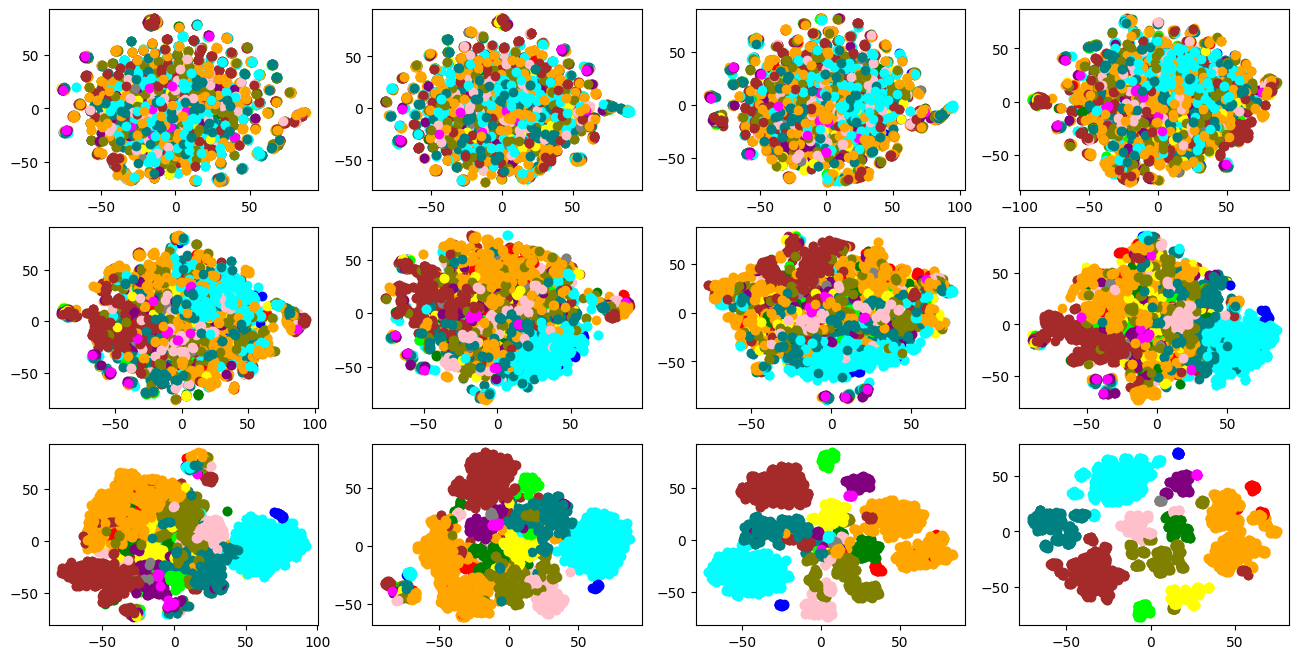

In [19]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

test_set = Data('./THUCNews', mode='Test')
load_test = DataLoader(
    test_set, 
    batch_size=1, 
    shuffle=False,  
    collate_fn=train_batchify_fn
)

load_test = [(token.to(device), label.to(device)) for token, label in tqdm(load_test)]

fig,axs = plt.subplots(3,4,figsize = (16,8))

for plt_id in range(12):
    plt_id

    points = []
    cols = []

    with torch.no_grad():
        for token, label in load_test:
            logit = model(**token)
            pred = torch.argmax(
                F.softmax(logit[0]),
                axis=-1
            )
            
            sentence_embedding = torch.mean(logit.hidden_states[plt_id + 1],dim = 0)
            points.append(sentence_embedding.cpu().detach().numpy())
            for i in range(len(sentence_embedding)):
                cols.append(pred.cpu().numpy())

    points = np.concatenate(points, axis=0)
    cols = np.concatenate(cols,axis=0)
    # print(len(cols))
    # print(cols)

    colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'lime', 'teal']

    tsne = TSNE(n_components=2, random_state=42)
    tsne_vectors = tsne.fit_transform(points)

    for point,col in zip(tsne_vectors,cols.astype(int)):
        axs[plt_id // 4,plt_id % 4].scatter(point[0], point[1],c = colors[col])
    
plt.show()

In [20]:
plt.savefig('./outputs2.jpg') 

<Figure size 640x480 with 0 Axes>